In [1]:
import os
import flow_vis
import imageio
import cv2 as cv
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.signal import convolve2d

In [2]:
%matplotlib inline

# Read images

In [3]:
images = []
dir = './Inputs'
for path in os.listdir(dir):
    images.append(cv.imread(dir+'/'+path, cv.COLOR_BGR2GRAY))


In [4]:
# Normalize images deviding by 255
images_norm = []
for img in images:
    images_norm.append(img/255)

In [12]:
path1 = './Inputs/frame1.png'
path2 = './Inputs/frame2.png'
img1 = cv.imread(path1, cv.COLOR_BGR2GRAY)/255
img2 = cv.imread(path2, cv.COLOR_BGR2GRAY)/255



# Find partial derivatives

In [10]:
def calc_gradients(img1, img2):
    kernelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernely = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    kernelt = np.ones((2, 2))

    gradx = convolve2d(img1, kernelx, mode="same") 
    grady = convolve2d(img1, kernely, mode="same") 
    #gradt = img1 - img2
    gradt = convolve2d(img1, kernelt, mode="same") + convolve2d(img2, -kernelt, mode="same")
    return [gradx, grady, gradt]

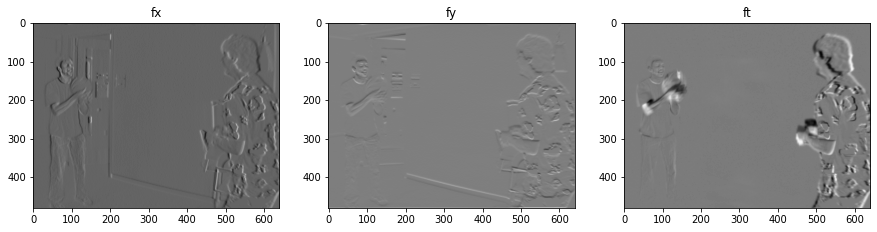

In [14]:
gradx, grady, gradt = calc_gradients(img1, img2)
gradx = (gradx - np.min(gradx))/(np.max(gradx) - np.min(gradx))*255
grady = (grady - np.min(grady))/(np.max(grady) - np.min(grady))*255
gradt = (gradt - np.min(gradt))/(np.max(gradt) - np.min(gradt))*255

#Plot partial derivatives
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(gradx.astype(np.uint8), cmap = "gray")
plt.title("fx")
plt.subplot(1, 3, 2)
plt.imshow(grady.astype(np.uint8), cmap = "gray")
plt.title("fy")
plt.subplot(1, 3, 3)
plt.imshow(gradt.astype(np.uint8), cmap = "gray")
plt.title("ft")
plt.savefig('partial_gradients.jpg')

# Horn - Schunck method

In [7]:
def HornSchunck(img1, img2, alpha = 10, niter = 20):
    u = np.zeros((img1.shape[0], img1.shape[1]))
    v = np.zeros((img1.shape[0], img1.shape[1]))
    kernel_avg = np.array(
        [[1 / 12, 1 / 6, 1 / 12], [1 / 6, 0, 1 / 6], [1 / 12, 1 / 6, 1 / 12]], float
    )

    gradx, grady, gradt = calc_gradients(img1, img2)

    for _ in range(niter):  
        u_avg = convolve2d(u, kernel_avg, mode='same') 
        v_avg = convolve2d(v, kernel_avg, mode='same')  
        fraction = (gradx*u_avg + grady*v_avg + gradt)/(np.square(alpha) + np.square(gradx) + np.square(grady))
        u = u_avg - gradx * fraction
        v = v_avg - grady * fraction    
    return u, v


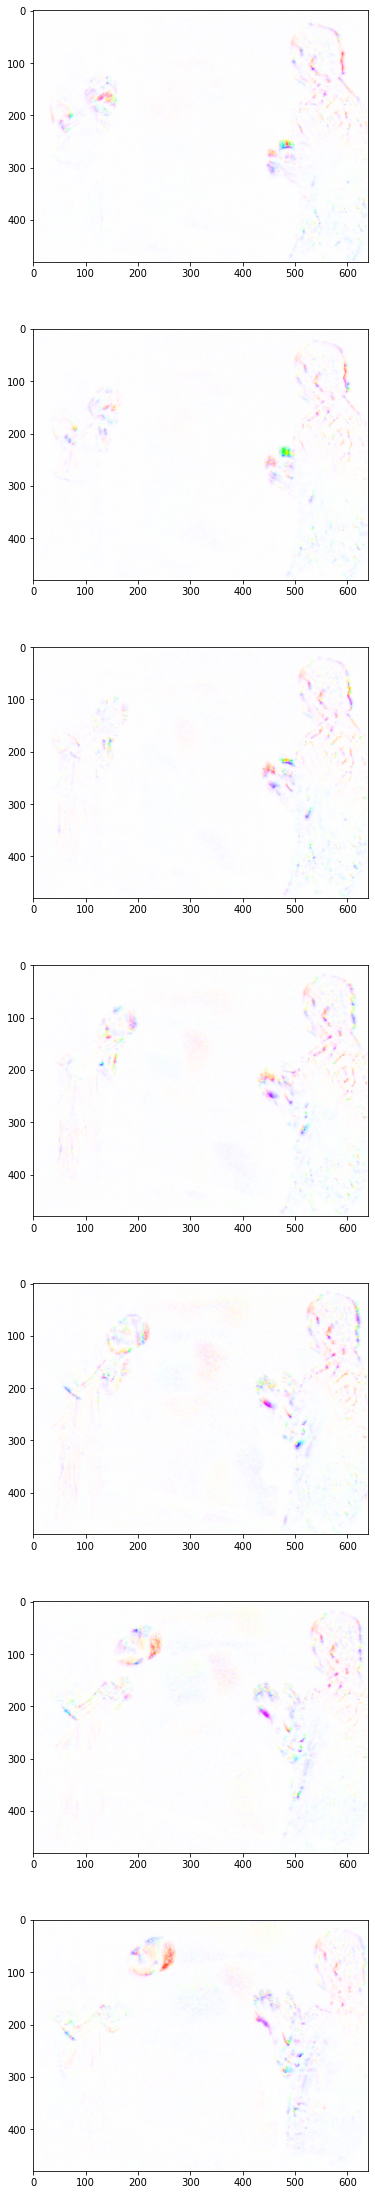

In [16]:
fig, ax = plt.subplots(7, 1, figsize=(6, 40))
for i in range(len(images)-1):
    #calcukate of vector for each pair of consecutive images
    u, v = HornSchunck(images[i], images[i+1], alpha=10, niter=20)
    flow_uv = np.stack((u, v), axis=2)

    flow_color = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    ax[i].imshow(flow_color)
    
    # save visualized optical flow between images
    extent = ax[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'./Outputs/HS/of_hs{i}.png', bbox_inches=extent)

#fig.savefig('./Outputs/res.jpg')



## Make gif

In [95]:
# Generate gif from derived images
images = []
for filename in os.listdir('./Outputs/HS'):
    images.append(imageio.imread('./Outputs/HS/'+filename))
imageio.mimsave('./Outputs/HS/opticalFlowHS.gif', images)

# Lucas-Kanade

In [21]:
def LucasKanade(img1, img2, winsize=10):
    #img1 = img1/255
    #img2 = img2/255
    u = np.zeros((img1.shape[0], img1.shape[1]))
    v = np.zeros((img1.shape[0], img1.shape[1]))
    w = int(winsize / 2)
    gradx, grady, gradt = calc_gradients(img1, img2)
    #print(img1.shape[1]-w, img1.shape[0]-w)
    for i in range(w, img1.shape[0]-w):
        for j in range(w, img1.shape[1]-w):
            Ix = gradx[i-w:i+w+1, j-w:j+w+1].flatten().reshape(-1, 1)
            Iy = grady[i-w:i+w+1, j-w:j+w+1].flatten().reshape(-1, 1)
            It = gradt[i-w:i+w+1, j-w:j+w+1].flatten().reshape(-1, 1)

            ssIx = np.sum(np.square(Ix))
            ssIy = np.sum(np.square(Iy))
            sIxIy = np.sum(Ix*Iy)
            
            m1 = np.zeros((2, 2))
            m1[0, 0] = ssIx
            m1[[0, 1], [1, 0]] = sIxIy
            m1[1, 1] = ssIy
            eig, v_ = np.linalg.eig(m1)
            #print(eig)
            m2 = np.array([[-(np.sum(Ix*It))],[-(np.sum(Iy*It))]])

            if (np.allclose(m1.dot(np.linalg.pinv(m1)), np.eye(2))):
                res = (np.linalg.pinv(m1)).dot(m2)
                u[i,j] = res[0, 0]
                v[i,j] = res [1, 0]        
            else:
                pass
                #print('Matrix is singular')         
            
    return u, v

In [ ]:
scale = np.eye(u.shape)

100%|██████████| 7/7 [13:57<00:00, 119.60s/it]


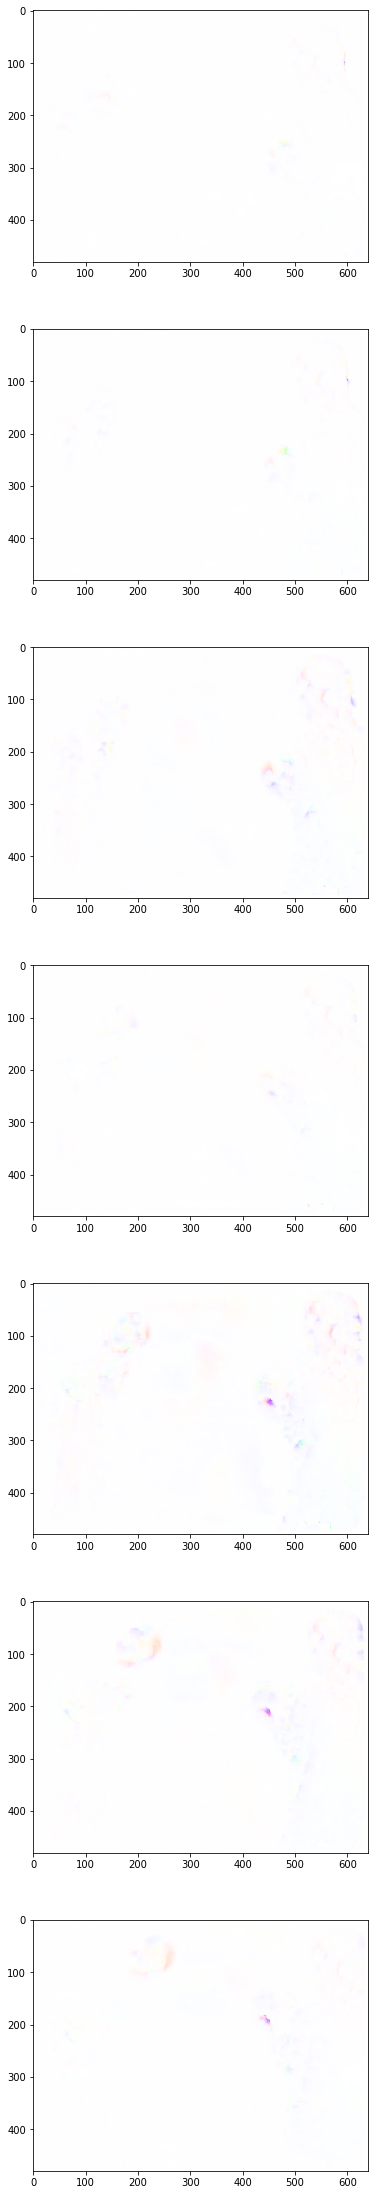

In [28]:
fig, ax = plt.subplots(7, 1, figsize=(6, 40))
winsize = 10
for i in tqdm(range(len(images_norm)-1)):
    #calcukate of vector for each pair of consecutive images
    u, v = LucasKanade(images_norm[i], images_norm[i+1], winsize=winsize)
    flow_uv = np.stack((4*u, 4*v), axis=2)

    flow_color = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    ax[i].imshow(flow_color)
    
    # save visualized optical flow between images
    extent = ax[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'./Outputs/LK/of_lk{i}.png', bbox_inches=extent)



# Make gif

In [27]:
# Generate gif from derived images
images = []
for filename in os.listdir('./Outputs/LK'):
    images.append(imageio.imread('./Outputs/LK/'+filename))
imageio.mimsave('./Outputs/LK/opticalFlowLK.gif', images)